1. Importing Libraries
Importing essential libraries for data processing, visualization, and model building.

In [1]:
import numpy as np
import tensorflow as tf
import random, os
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# 🔒 Fix random seeds for reproducibility
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

2025-11-01 13:13:35.342991: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762002815.524490      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762002815.586941      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


2. Data Loading & Preprocessing
Loading the dataset, splitting into train/validation/test sets, and applying data augmentation.

In [2]:
# paths
base_dir = "/kaggle/input/chest-xray-pneumonia/chest_xray"

train_dir = "/kaggle/input/chest-xray-pneumonia/chest_xray/train"
val_dir = "/kaggle/input/chest-xray-pneumonia/chest_xray/val"
test_dir = "/kaggle/input/chest-xray-pneumonia/chest_xray/test"

train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.15,
    subset="training",
    seed=123,
    image_size=(224, 224),
    batch_size=32,
    labels='inferred',
    label_mode='binary'
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.15,
    subset="validation",
    seed=123,
    image_size=(224, 224),
    batch_size=32,
    labels='inferred',
    label_mode='binary'
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=(224, 224),
    batch_size=32,
    labels='inferred',
    label_mode='binary'
)

Found 5216 files belonging to 2 classes.
Using 4434 files for training.


I0000 00:00:1762002844.925281      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Found 5216 files belonging to 2 classes.
Using 782 files for validation.
Found 624 files belonging to 2 classes.


3. Class Weights

To handle imbalance between Normal and Pneumonia images, class weights are calculated and passed to model.fit() so both classes are treated equally during training.

In [4]:
labels = np.concatenate([y.numpy().astype(int).reshape(-1,) for x, y in train_ds], axis=0)
classes = np.unique(labels)
class_weights_raw = compute_class_weight(class_weight='balanced', classes=classes, y=labels)
class_weights = {int(c): float(w) for c, w in zip(classes, class_weights_raw)}
print("Class weights:", class_weights)

Class weights: {0: 1.916162489196197, 1: 0.6765334147085749}


In [5]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000, seed=seed).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [6]:
# Data augmentation block (on-the-fly)
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.08), #0.08
    layers.RandomZoom(0.10),  #0.10
    layers.RandomContrast(0.15), #0.15
], name="data_augmentation")

4. Building the Base Model (Feature Extraction)
Using pretrained ResNet50 as the backbone for feature extraction.
The base model weights are frozen in this step.

In [7]:
from tensorflow.keras.applications import ResNet50
base_model = tf.keras.applications.ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(224,224,3),
    pooling='avg' 
)
base_model.trainable = False   #

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [8]:
# Building the full model (Functional API for clarity)
inputs = tf.keras.Input(shape=(224,224,3))
x = data_augmentation(inputs)
x = layers.Lambda(tf.keras.applications.resnet50.preprocess_input)(x)
x = base_model(x, training=False)
x = layers.Dropout(0.5)(x)
x = layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs, outputs, name="resnet50_transfer")

In [11]:
# Compile (train top head)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), 
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

In [10]:
model.summary()

Model: "resnet50_transfer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 2048)           │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,850,625 (90.98 MB)

 Trainable params: 262,657 (1.00 MB)

 Non-trainable params: 23,587,968 (89.98 MB)

In [12]:
# Callbacks 
early_stop = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-7)
chkpt_head = ModelCheckpoint("best_model_head.keras", monitor="val_loss", save_best_only=True, mode="min")
csv_logger = tf.keras.callbacks.CSVLogger('training_log.csv', append=True)

In [13]:
history_head = model.fit(train_ds, validation_data=val_ds, epochs=20, class_weight=class_weights, callbacks=[early_stop, reduce_lr, chkpt_head, csv_logger])

Epoch 1/20


I0000 00:00:1760605543.338035     104 cuda_dnn.cc:529] Loaded cuDNN version 90300


139/139 ━━━━━━━━━━━━━━━━━━━━ 49s 137ms/step - accuracy: 0.6346 - auc: 0.7388 - loss: 0.9244 - val_accuracy: 0.8376 - val_auc: 0.9818 - val_loss: 0.6461 - learning_rate: 1.0000e-04
Epoch 2/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 13s 97ms/step - accuracy: 0.7866 - auc: 0.9307 - loss: 0.6211 - val_accuracy: 0.8785 - val_auc: 0.9855 - val_loss: 0.5602 - learning_rate: 1.0000e-04
Epoch 3/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 13s 96ms/step - accuracy: 0.8243 - auc: 0.9500 - loss: 0.5594 - val_accuracy: 0.9156 - val_auc: 0.9876 - val_loss: 0.4632 - learning_rate: 1.0000e-04
Epoch 4/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 13s 96ms/step - accuracy: 0.8344 - auc: 0.9554 - loss: 0.5322 - val_accuracy: 0.9194 - val_auc: 0.9891 - val_loss: 0.4338 - learning_rate: 1.0000e-04
Epoch 5/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 13s 96ms/step - accuracy: 0.8646 - auc: 0.9671 - loss: 0.4880 - val_accuracy: 0.9284 - val_auc: 0.9898 - val_loss: 0.4069 - learning_rate: 1.0000e-04
Epoch 6/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 13s 96ms/step - accu

In [14]:
test_loss, test_acc, test_auc = model.evaluate(test_ds)
print(f"\nHead-only Test Accuracy: {test_acc:.4f}, Test AUC: {test_auc:.4f}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 0.8718 - auc: 0.9520 - loss: 0.4740

Head-only Test Accuracy: 0.8558, Test AUC: 0.9458


5. Fine-Tuning the Model
Unfreezing the top layers of ResNet50 and retraining to improve performance.

In [15]:
base_model.trainable = True
fine_tune_at = len(base_model.layers) - 30
for i, layer in enumerate(base_model.layers):
    layer.trainable = (i >= fine_tune_at)

In [16]:
# Recompiling with a very low learning rate
model.compile( optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])

In [17]:
chkpt_finetune = ModelCheckpoint("best_model_finetuned.keras", monitor="val_loss", save_best_only=True, mode="min")

In [18]:
history_finetune = model.fit(train_ds, validation_data=val_ds, epochs=20, class_weight=class_weights, callbacks=[early_stop, reduce_lr, chkpt_finetune])

Epoch 1/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 39s 153ms/step - accuracy: 0.9085 - auc: 0.9756 - loss: 0.3946 - val_accuracy: 0.9194 - val_auc: 0.9886 - val_loss: 0.4050 - learning_rate: 1.0000e-05
Epoch 2/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 18s 127ms/step - accuracy: 0.9323 - auc: 0.9857 - loss: 0.3328 - val_accuracy: 0.9348 - val_auc: 0.9918 - val_loss: 0.3641 - learning_rate: 1.0000e-05
Epoch 3/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 18s 127ms/step - accuracy: 0.9483 - auc: 0.9899 - loss: 0.3011 - val_accuracy: 0.9348 - val_auc: 0.9923 - val_loss: 0.3634 - learning_rate: 1.0000e-05
Epoch 4/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 16s 116ms/step - accuracy: 0.9567 - auc: 0.9912 - loss: 0.2886 - val_accuracy: 0.9297 - val_auc: 0.9929 - val_loss: 0.3742 - learning_rate: 1.0000e-05
Epoch 5/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 16s 116ms/step - accuracy: 0.9576 - auc: 0.9929 - loss: 0.2812 - val_accuracy: 0.9348 - val_auc: 0.9942 - val_loss: 0.3662 - learning_rate: 1.0000e-05
Epoch 6/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 18s 1

In [19]:
# Final evaluation 
test_loss, test_acc, test_auc = model.evaluate(test_ds)
print(f"\nFine-tuned Test Accuracy: {test_acc:.4f}, Test AUC: {test_auc:.4f}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.9106 - auc: 0.9481 - loss: 0.4533

Fine-tuned Test Accuracy: 0.8974, Test AUC: 0.9446


In [20]:
from sklearn.metrics import confusion_matrix, classification_report

# Predict once
y_true = np.concatenate([y for x, y in test_ds], axis=0)
y_pred_probs = model.predict(test_ds)
y_pred_label = (y_pred_probs >= 0.5).astype(int)

print("Classification Report:\n", classification_report(y_true, y_pred_label, digits=2))
cm = confusion_matrix(y_true, y_pred_label)
print("Confusion Matrix:\n", cm)


20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 183ms/step
Classification Report:
               precision    recall  f1-score   support

         0.0       0.92      0.79      0.85       234
         1.0       0.89      0.96      0.92       390

    accuracy                           0.90       624
   macro avg       0.90      0.88      0.89       624
weighted avg       0.90      0.90      0.90       624

Confusion Matrix:
 [[186  48]
 [ 16 374]]


In [7]:
y_pred_optimal = (y_pred_probs >= 0.54).astype(int)
print(confusion_matrix(y_true, y_pred_optimal))
print(classification_report(y_true, y_pred_optimal, digits=2))

[[188  46]
 [ 16 374]]
              precision    recall  f1-score   support

         0.0       0.92      0.80      0.86       234
         1.0       0.89      0.96      0.92       390

    accuracy                           0.90       624
   macro avg       0.91      0.88      0.89       624
weighted avg       0.90      0.90      0.90       624



6. Saving the Model
Saving the best performing model for inference and deployment.

In [32]:
model.save("/kaggle/working/final_resnet_pneumonia_model.keras")

In [3]:
# testing saved model
import numpy as np
import tensorflow as tf
import random, os
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

test_dir = "/kaggle/input/chest-xray-pneumonia/chest_xray/test"
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=(224, 224),
    batch_size=32,
    labels='inferred',
    label_mode='binary'
)
AUTOTUNE = tf.data.AUTOTUNE
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 624 files belonging to 2 classes.


In [2]:
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.resnet50 import preprocess_input

model = load_model(
    "/kaggle/input/pneumonia-keras-model/final_resnet_pneumonia_model.keras",
    custom_objects={'preprocess_input': preprocess_input}
)

print("✅ Model loaded successfully!")

2025-10-28 16:48:32.444557: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761670112.654529      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761670112.724329      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
I0000 00:00:1761670124.907972      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


✅ Model loaded successfully!


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step


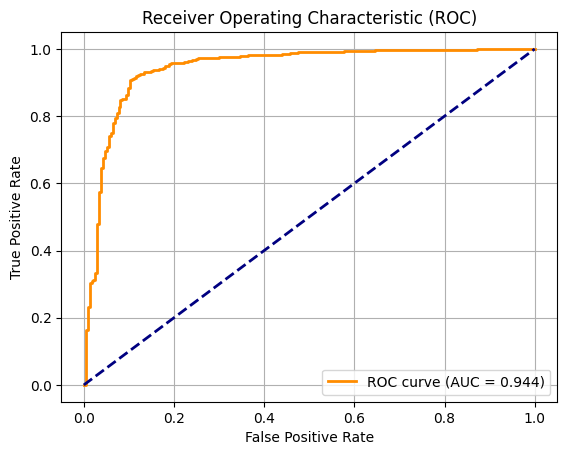

✅ ROC curve saved successfully!


In [5]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import os
import numpy as np

# Predict probabilities
y_true = np.concatenate([y for x, y in test_ds], axis=0)
y_pred = model.predict(test_ds).ravel()

# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.grid(True)
plt.savefig('roc_curve.png', dpi=300)
plt.close()
plt.show()

print("✅ ROC curve saved successfully!")


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step


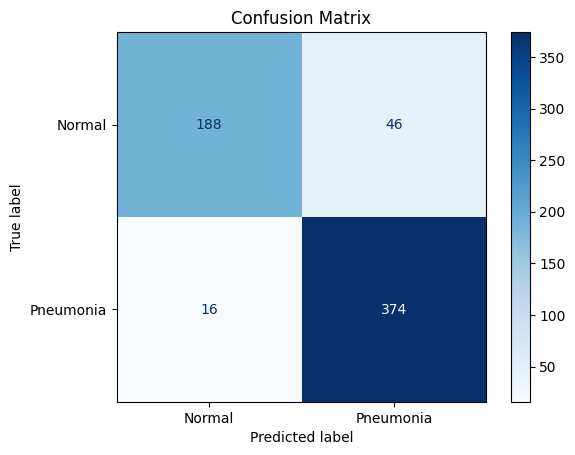

✅ Confusion matrix saved successfully!


In [6]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# get true and predicted labels
y_true = np.concatenate([y for x, y in test_ds], axis=0)
y_pred = model.predict(test_ds)
y_pred_classes = np.argmax(y_pred, axis=1) if y_pred.shape[1] > 1 else (y_pred > 0.54).astype("int32")

# confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Pneumonia'])
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.savefig('confusion_matrix.png', dpi=300)
plt.close()
plt.show()

print("✅ Confusion matrix saved successfully!")


7. Grad-CAM Visualization
Generating heatmaps to visualize which regions influenced the model’s decision.

In [7]:
# Get one batch for Grad-CAM inspection
test_images, test_labels = next(iter(test_ds))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


/tmp/ipykernel_36/2297913417.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  true_label = int(test_labels[3].numpy())


✅ True label: 1, Predicted class: 1, Probability: 0.9985


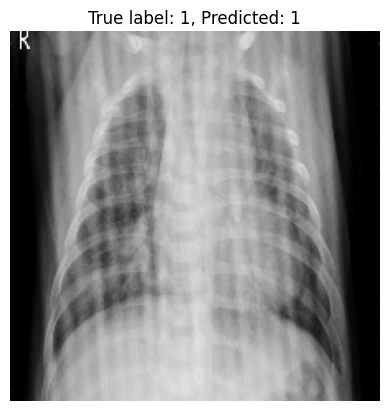

✅ Using last conv layer: conv5_block3_3_conv


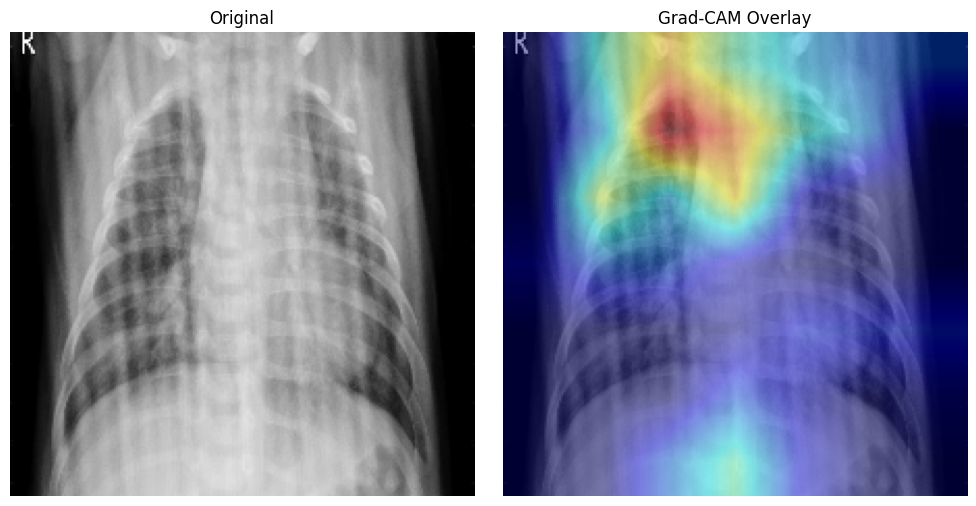

In [24]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2

# 🔹 Pick a sample image from test set
img_tensor = test_images[3]
true_label = int(test_labels[3].numpy())

# 🔹 Predict class for the image
pred = model.predict(tf.expand_dims(img_tensor, axis=0))
prob = float(pred[0][0]) if pred.shape[-1] == 1 else float(np.max(pred))
pred_class = int(prob > 0.54) if pred.shape[-1] == 1 else np.argmax(pred)

print(f"✅ True label: {true_label}, Predicted class: {pred_class}, Probability: {prob:.4f}")

# 🔹 Convert to uint8 for visualization
img_np = img_tensor.numpy()
img_uint8 = (img_np * 255).astype(np.uint8) if img_np.max() <= 1 else np.clip(img_np, 0, 255).astype(np.uint8)

plt.imshow(img_uint8)
plt.title(f"True label: {true_label}, Predicted: {pred_class}")
plt.axis("off")
plt.show()

# 🔹 Access ResNet50 backbone safely
resnet_base = None
for layer in model.layers:
    if "resnet" in layer.name.lower():
        resnet_base = layer
        break

if resnet_base is None:
    raise ValueError("❌ Could not find ResNet backbone inside model!")

# 🔹 Find the last conv layer dynamically (no guessing names)
last_conv_layer = None
for layer in reversed(resnet_base.layers):
    if isinstance(layer, tf.keras.layers.Conv2D):
        last_conv_layer = layer.name
        break

if last_conv_layer is None:
    raise ValueError("❌ No Conv2D layer found in ResNet base!")

print(f"✅ Using last conv layer: {last_conv_layer}")

conv_model = tf.keras.Model(
    inputs=resnet_base.input,
    outputs=resnet_base.get_layer(last_conv_layer).output
)

# 🔹 Grad-CAM Function
def make_gradcam_heatmap(img_tensor, full_model, backbone_conv_model):
    img_tensor = tf.cast(tf.expand_dims(img_tensor, axis=0), tf.float32)

    # Apply preprocessing same as training
    x = full_model.get_layer("data_augmentation")(img_tensor)
    x = full_model.get_layer("lambda")(x)

    with tf.GradientTape() as tape:
        conv_outputs = backbone_conv_model(x, training=False)
        tape.watch(conv_outputs)

        gap_output = tf.reduce_mean(conv_outputs, axis=(1, 2))  # mimic global avg pooling
        x = full_model.get_layer("dropout")(gap_output, training=False)
        x = full_model.get_layer("dense")(x, training=False)
        x = full_model.get_layer("batch_normalization")(x, training=False)
        x = full_model.get_layer("dropout_1")(x, training=False)
        preds = full_model.get_layer("dense_1")(x, training=False)

        pred_index = tf.argmax(preds[0])
        grads = tape.gradient(preds[:, pred_index], conv_outputs)

    if grads is None:
        raise RuntimeError("❌ Gradients are None — check layer mapping or names.")

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_output = conv_outputs[0]
    heatmap = tf.reduce_sum(conv_output * pooled_grads, axis=-1)
    heatmap = tf.maximum(heatmap, 0)
    heatmap /= tf.reduce_max(heatmap) + 1e-8
    return heatmap.numpy()

# 🔹 Generate heatmap
heatmap = make_gradcam_heatmap(img_tensor, model, conv_model)

# 🔹 Overlay
def overlay_gradcam(original_img, heatmap, alpha=0.4):
    heatmap_resized = cv2.resize(heatmap, (original_img.shape[1], original_img.shape[0]))
    heatmap_color = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
    heatmap_color = cv2.cvtColor(heatmap_color, cv2.COLOR_BGR2RGB)
    superimposed = cv2.addWeighted(original_img, 1 - alpha, heatmap_color, alpha, 0)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(original_img)
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(superimposed)
    plt.title("Grad-CAM Overlay")
    plt.axis("off")
    plt.tight_layout()
    plt.savefig('Grad-CAM Pneumonia.png', dpi=300)
    plt.show()

overlay_gradcam(img_uint8, heatmap)

In [ ]:
# Medical-Image-Classification/ │ ├── model/ │ └── best_resnet_head.keras │ ├── notebooks/ │ └── pneumonia_project.ipynb │ ├── src/ │ ├── model_builder.py │ ├── train.py │ ├── gradcam_utils.py │ └── evaluate.py │ ├── assets/ │ ├── roc_curve.png │ ├── confusion_matrix.png │ └── gradcam_grid.png │ ├── requirements.txt ├── README.md └── .gitignore